Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""
def extract(filename, folder):
    """Extract a zip/tar file into folder."""

Read-In and Download Dataset

In [3]:
class House_Pred(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                            d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                            sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                            d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                            sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [4]:
data = House_Pred(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


Preprocess Dataset

In [5]:
print(data.raw_train.iloc[:10, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000
5   6          50       RL         85.0       WD        Normal     143000
6   7          20       RL         75.0       WD        Normal     307000
7   8          60       RL          NaN       WD        Normal     200000
8   9          50       RM         51.0       WD       Abnorml     129900
9  10         190       RL         50.0       WD        Normal     118000


In [6]:
data.raw_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
print(data.raw_val.iloc[:10, [0, 1, 2, 3, -3, -2, -1]])

     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal
4  1465         120       RL         43.0    2010       WD        Normal
5  1466          60       RL         75.0    2010       WD        Normal
6  1467          20       RL          NaN    2010       WD        Normal
7  1468          60       RL         63.0    2010       WD        Normal
8  1469          20       RL         85.0    2010       WD        Normal
9  1470          20       RL         70.0    2010       WD        Normal


In [8]:
data.raw_val.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
@d2l.add_to_class(House_Pred)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
        self.raw_val.drop(columns=['Id'])))
    
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
                                lambda x: (x - x.mean()) / (x.std()))
    
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [10]:
data.preprocess()
data.train.shape

(1460, 332)

Error Measure

In [11]:
@d2l.add_to_class(House_Pred)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])), # X
            torch.log(get_tensor(data[label])).reshape((-1, 1))) # Y
    return self.get_tensorloader(tensors, train)

K-Fold Cross-Val

In [12]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(House_Pred(data.batch_size, data.train.drop(index=idx),
                    data.train.loc[idx]))
        return rets

In [13]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

Model Selection

average validation log mse = 0.12309316359460354


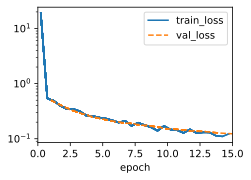

In [14]:
trainer = d2l.Trainer(max_epochs=15)
models = k_fold(trainer, data, k=7, lr=0.01)

In [16]:
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
        for model in models]

# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
predictions = pd.DataFrame({'Id':data.raw_val.Id,
            'SalePrice':ensemble_preds.detach().numpy()})
predictions.to_csv('predictions.csv', index=False)